# Interactive Vent Field Coordinate Picker (Site Overview)

Click on the caldera overview map to pick/adjust vent field locations.
Map uses UTM Zone 9N projection for correct aspect ratio.
Clicked coordinates are reported in both UTM (easting/northing) and lon/lat.

- **Left-click** to add a point
- **Right-click** to remove last point

## Pick order (south to north)

| Pick # | Vent Field       | Location hint                          |
|--------|------------------|----------------------------------------|
| 1      | Coquille         | Southern end, east side of caldera     |
| 2      | Int'l District   | South-central, east side               |
| 3      | ASHES            | Central caldera, west side             |
| 4      | Trevi            | Central-east, east of ASHES            |
| 5      | CASM             | Northern caldera, near north wall      |

In [1]:
%matplotlib widget

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from pathlib import Path
import cartopy.crs as ccrs

# 1m AUV bathymetry (same as make_vent_map.py)
BATHY_PATH = Path("/home/jovyan/my_data/axial/axial_bathy/MBARI_AxialSeamount_V2506_AUV_Summit_AUVOverShip_Topo1mSq.grd")

# Projections — UTM zone 9N (130°W falls in zone 9: 132°W–126°W)
UTM9N = ccrs.UTM(zone=9, southern_hemisphere=False)
LONLAT = ccrs.PlateCarree()

# Pick order (south to north) — must match the table in the markdown cell
PICK_ORDER = ["Coquille", "Int'l District", "ASHES", "Trevi", "CASM"]

# Current vent field locations (from make_vent_map.py)
CURRENT_FIELDS = {
    "ASHES":           {"lon": -(130 + 0.8203/60),  "lat": 45 + 56.0186/60},
    "Coquille":        {"lon": -(129 + 59.5793/60), "lat": 45 + 55.0448/60},
    "Int'l District":  {"lon": -(129 + 58.7394/60), "lat": 45 + 55.5786/60},
    "Trevi":           {"lon": -(129 + 59.023/60),  "lat": 45 + 56.777/60},
    "CASM":            {"lon": -(130 + 1.632/60),   "lat": 45 + 59.332/60},
}

# Store picked points (in UTM coordinates)
picked_points = []
point_markers = []
point_labels = []

In [2]:
# Load 1m bathymetry and clip to caldera extent (same as make_vent_map.py main())
center_lon = -130.008772
center_lat = 45.95485
half_width = 0.038    # trimmed 2 km inward from original 0.064
half_height = 0.043   # trimmed 2 km inward from original 0.061

print("Loading bathymetry...")
ds = xr.open_dataset(BATHY_PATH)
ds = ds.sel(
    lon=slice(center_lon - half_width, center_lon + half_width),
    lat=slice(center_lat - half_height, center_lat + half_height),
)

lon = ds.coords['lon'].values
lat = ds.coords['lat'].values
z = ds['z'].values
ds.close()

# Build UTM extent from corners
corner_lons = np.array([lon.min(), lon.max(), lon.max(), lon.min()])
corner_lats = np.array([lat.min(), lat.min(), lat.max(), lat.max()])
corners_utm = UTM9N.transform_points(LONLAT, corner_lons, corner_lats)
x_utm_min, x_utm_max = corners_utm[:, 0].min(), corners_utm[:, 0].max()
y_utm_min, y_utm_max = corners_utm[:, 1].min(), corners_utm[:, 1].max()

print(f"Grid: {len(lon)} x {len(lat)}")
print(f"UTM Easting:  {x_utm_min:.1f} to {x_utm_max:.1f} m")
print(f"UTM Northing: {y_utm_min:.1f} to {y_utm_max:.1f} m")
print(f"Depth: {np.nanmin(z):.0f} to {np.nanmax(z):.0f} m")

Loading bathymetry...
Grid: 5893 x 6668
UTM Easting:  418818.1 to 424827.4 m
UTM Northing: 5084712.9 to 5094340.1 m
Depth: -1634 to -1334 m


In [3]:
def utm_to_lonlat(easting, northing):
    """Convert UTM zone 9N coordinates back to lon/lat."""
    pt = LONLAT.transform_point(easting, northing, UTM9N)
    return pt[0], pt[1]

def on_click(event):
    """Handle mouse click events - coordinates are in UTM."""
    global picked_points, point_markers, point_labels, ax, fig

    if event.inaxes is None:
        return

    # Right-click to remove last point
    if event.button == 3:
        if picked_points:
            picked_points.pop()
            if point_markers:
                marker = point_markers.pop()
                marker.remove()
            if point_labels:
                label = point_labels.pop()
                label.remove()
            fig.canvas.draw()
            next_idx = len(picked_points)
            next_name = PICK_ORDER[next_idx] if next_idx < len(PICK_ORDER) else "done"
            print(f"Removed last point. Next pick: #{next_idx+1} {next_name}")
        return

    # Left-click to add point
    if event.button == 1:
        easting, northing = event.xdata, event.ydata
        lon, lat = utm_to_lonlat(easting, northing)
        pick_idx = len(picked_points)
        pick_name = PICK_ORDER[pick_idx] if pick_idx < len(PICK_ORDER) else f"Extra_{pick_idx+1}"
        picked_points.append((easting, northing, lon, lat))

        # Add small marker
        marker, = ax.plot(easting, northing, 'ro', markersize=4,
                          markeredgecolor='white', markeredgewidth=1, zorder=20)
        point_markers.append(marker)

        # Add label with pick number and name
        label = ax.annotate(f'{pick_idx+1}: {pick_name}', (easting, northing),
                            xytext=(10, 10), textcoords='offset points',
                            fontsize=9, fontweight='bold', color='red',
                            bbox=dict(boxstyle='round,pad=0.3',
                                     facecolor='white', alpha=0.9),
                            zorder=21)
        point_labels.append(label)

        fig.canvas.draw()
        print(f"Pick {pick_idx+1} ({pick_name}): E={easting:.1f} N={northing:.1f}  (lon={lon:.6f}, lat={lat:.6f})")
        # Prompt next
        next_idx = pick_idx + 1
        if next_idx < len(PICK_ORDER):
            print(f"  -> Next: #{next_idx+1} {PICK_ORDER[next_idx]}")
        else:
            print("  -> All 5 fields picked! Run the output cell.")

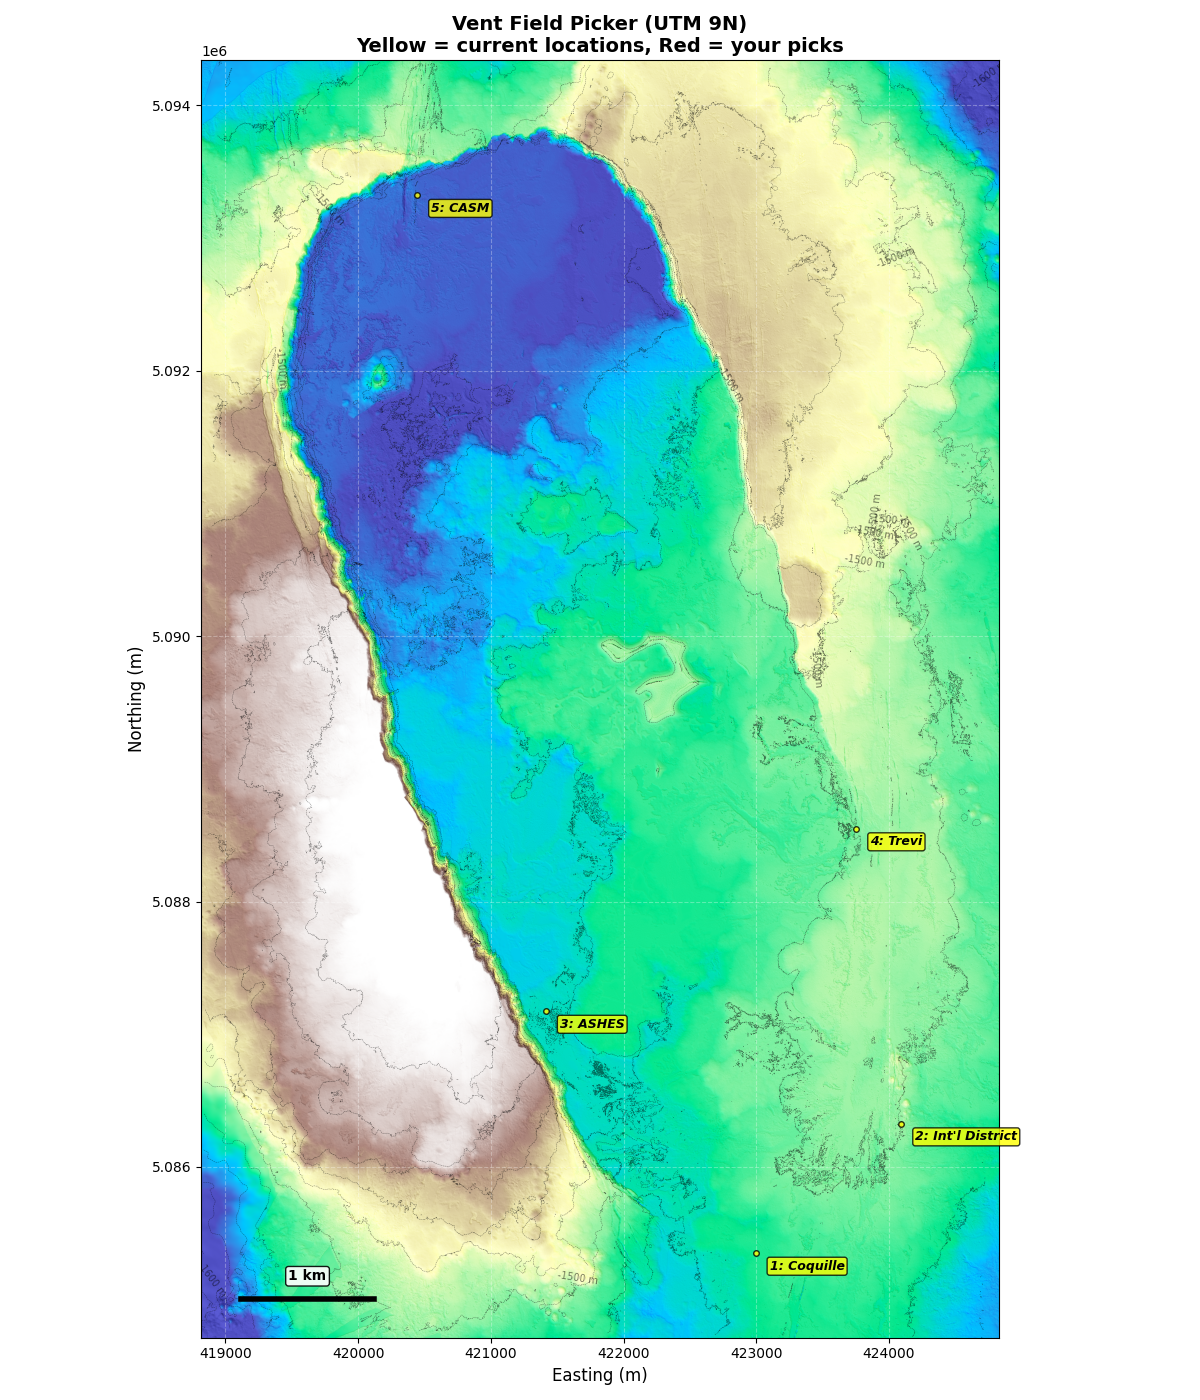

PICK ORDER (south to north):
  1. Coquille
  2. Int'l District
  3. ASHES
  4. Trevi
  5. CASM
LEFT-CLICK to add points, RIGHT-CLICK to remove last point


In [4]:
# Create the interactive map in UTM projection
fig, ax = plt.subplots(figsize=(12, 14))

# Create shaded relief
ls = LightSource(azdeg=315, altdeg=45)
z_min, z_max = np.nanpercentile(z, [2, 98])
rgb = ls.shade(z, cmap=plt.cm.terrain, blend_mode='soft',
               vmin=z_min, vmax=z_max)

# Plot in UTM coordinates
ax.imshow(rgb, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max],
          origin='lower', aspect='equal')

# Add depth contours in UTM (20m interval, matching Map 1)
lon_grid, lat_grid = np.meshgrid(lon, lat)
pts_utm = UTM9N.transform_points(LONLAT, lon_grid, lat_grid)
x_utm_grid = pts_utm[:, :, 0]
y_utm_grid = pts_utm[:, :, 1]
contour_levels = np.arange(-2200, -1400, 20)
cs = ax.contour(x_utm_grid, y_utm_grid, z, levels=contour_levels,
                colors='black', linewidths=0.3, alpha=0.5)
ax.clabel(cs, levels=contour_levels[::5], fontsize=7, fmt='%d m', inline=True)

# Plot current vent field locations — small markers with pick-order numbers
for i, name in enumerate(PICK_ORDER):
    info = CURRENT_FIELDS[name]
    pt = UTM9N.transform_point(info['lon'], info['lat'], LONLAT)
    ax.plot(pt[0], pt[1], 'o', markersize=4,
            markerfacecolor='yellow', markeredgecolor='black',
            markeredgewidth=1, alpha=0.8, zorder=10)
    ax.annotate(f'{i+1}: {name}', (pt[0], pt[1]),
                xytext=(10, -12), textcoords='offset points',
                fontsize=9, fontweight='bold', style='italic',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow',
                         alpha=0.8, edgecolor='black'),
                zorder=11)

ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.set_title('Vent Field Picker (UTM 9N)\n'
             'Yellow = current locations, Red = your picks',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', color='white')

# 1 km scale bar (exact in UTM meters)
scale_x = x_utm_min + (x_utm_max - x_utm_min) * 0.05
scale_y = y_utm_min + (y_utm_max - y_utm_min) * 0.03
ax.plot([scale_x, scale_x + 1000], [scale_y, scale_y], 'k-', linewidth=4)
ax.text(scale_x + 500, scale_y + (y_utm_max - y_utm_min) * 0.015, '1 km',
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9))

# Connect click event
fig.canvas.mpl_connect('button_press_event', on_click)

plt.tight_layout()
plt.show()

print("="*60)
print("PICK ORDER (south to north):")
for i, name in enumerate(PICK_ORDER):
    print(f"  {i+1}. {name}")
print("="*60)
print("LEFT-CLICK to add points, RIGHT-CLICK to remove last point")

In [ ]:
# Run this cell to see all picked coordinates
print("PICKED VENT FIELD COORDINATES")
print("=" * 60)
if picked_points:
    for i, (e, n, lon, lat) in enumerate(picked_points):
        name = PICK_ORDER[i] if i < len(PICK_ORDER) else f"Point_{i+1}"
        print(f"  {i+1}. {name}: E={e:.1f} N={n:.1f}  (lon={lon:.6f}, lat={lat:.6f})")

    print("\n# Copy this into make_vent_map.py plot_site_map():")
    print("    all_vent_fields = {")
    for i, (e, n, lon, lat) in enumerate(picked_points):
        name = PICK_ORDER[i] if i < len(PICK_ORDER) else f"Point_{i+1}"
        print(f'        "{name}": {{"lon": {lon:.6f}, "lat": {lat:.6f}}},')
    print("    }")
else:
    print("No points picked yet. Click on the map above.")